**Problem Inspiration:**

Since its release, ChatGPT has received extensive user feedback through ratings and textual reviews. Analyzing this feedback to understand user sentiment and identify key factors influencing satisfaction or dissatisfaction is essential for refining the product and improving the overall user experience.

The key objectives I am going to focus in this notebook are:
1. **Sentiment Analysis:** Examine the overall sentiment distribution among users and pinpoint the specific aspects of ChatGPT that they appreciate or find lacking.
2. **Time-Series Analysis:** Track and evaluate how user sentiment has changed over time.
3. **Net Promoter Score (NPS) Analysis:** Calculate and visualize the NPS over time to gauge user loyalty and their likelihood of recommending ChatGPT.
4. **Issue Identification:** Detect the most frequent issues users encounter, particularly those contributing to negative reviews.

# **Step 1: Importing libraries and loading data**

In [ ]:
#importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
import plotly.graph_objects as go

In [ ]:
#loading the data
reviews=pd.read_csv("chatgpt_reviews.csv")

In [ ]:
#checking how the data looks like
reviews.head()

,Review Id,Review,Ratings,Review Date
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39


So we see that main columns are: Review and what is the rating corresponding to that review.

And then we have review date that we will be using to see how the user experience and feedback is changing with time. Hence the second key objective time series analysis.

In [ ]:
#checking the data types of the columns
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


# **Step 2: Data prepartaion**

## **Step 2.1: Checking and handling null values**

In [ ]:
#now a sanity check we always do is to check the null values present in the data
reviews.isnull().sum()

,0
Review Id,0
Review,6
Ratings,0
Review Date,0


So we have around 6 columns in the review where we have null data. We can simply either remove them or replace the null string with value of NA.

In [ ]:
#checking in review what is the percentage of null values
reviews['Review'].isnull().sum()/ len(reviews) * 100

0.0030499118067169226

In [ ]:
#dropping the null values since the percentage is very low
reviews = reviews.dropna(subset=['Review'])

In [ ]:
#checking the null values
reviews.isnull().sum()

,0
Review Id,0
Review,0
Ratings,0
Review Date,0


**Now we see that null values have been dropped.**

Important: Please note before dropping I have analyzed what is the percentage of the missing values present in the dataset. Since the number was very small I directly removed those rows. In case we have a high percentage, we can go for imputing these values or filling these entries with NA string.

## **Step 2.2: Fixing the data types**

In [ ]:
#checking the data types once again
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 196721 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196721 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196721 non-null  int64 
 3   Review Date  196721 non-null  object
dtypes: int64(1), object(3)
memory usage: 7.5+ MB


In [ ]:
#since later we will be using the time series analysis converting the Review Date to datetime format
reviews['Review Date'] = pd.to_datetime(reviews['Review Date'])

# **Step 3: Adding the sentiment labels to the review content**

Now there are many different ways to do sentiment labelling. In the below code block we will use the method TextBlob.

Textblob is a library we use for processing textual data.
TextBlob can analyze the sentiment of a given text, returning polarity (sentiment orientation) and subjectivity (how subjective or objective the text is).
1. Polarity ranges from -1 (negative) to 1 (positive).
2. Subjectivity ranges from 0 (objective) to 1 (subjective).

In [ ]:
#since we have a large dataset, defining a function to determine the sentiment polarity
from textblob import TextBlob

def sentiment(review):
  sentiment=TextBlob(review).sentiment.polarity
  if sentiment>0:
    return 'Positive'
  elif sentiment<0:
    return 'Negative'
  else:
    return 'Neutral'

In [ ]:
#applying the sentiment analysis
#to store the sentiment we will create a new block
reviews['Sentiment']= reviews['Review'].apply(sentiment)

In [ ]:
#analyzing the few sentiment
reviews.head()

,Review Id,Review,Ratings,Review Date,Sentiment
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05,Positive
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18,Positive
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59,Positive
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50,Positive
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39,Positive


In [ ]:
#checking the distribution of reviews
sentiment_counts = reviews['Sentiment'].value_counts()
print(sentiment_counts)

Sentiment
Positive    150122
Neutral      38444
Negative      8155
Name: count, dtype: int64


In [ ]:
#checking the percentage of sentiment
sentiment_percentages = reviews['Sentiment'].value_counts(normalize=True) * 100
print(sentiment_percentages)

Sentiment
Positive    76.312137
Neutral     19.542398
Negative     4.145465
Name: proportion, dtype: float64


In [ ]:
#plotting the distribution
figure= go.Figure([go.Bar(x=sentiment_counts.index, y=sentiment_counts.values, marker_color=['green', 'gray', 'red'])])

figure.update_layout(title='Sentiment Distribution of ChatGPT reviews', xaxis_title='Sentiment', yaxis_title='Count')
figure.show()


So from the above distribution we see that maximum users have a very positive review, more than 140K and very few users carry neutral and negative sentiment.



# **Step 4: Analysis of what users like about ChatGPT**

In the below section I will focus on extracting what are the commonly occurring phrases and keywords from the reviews with positive sentiments. This will help us to identify features that users are using which they really like.

What steps will be done in this section:
1. Filtering views that have a positive sentiment and creating a wordcloud for most frequently used words
2. Extracting and analyzing the most common phrases and keywords from the reviews.

## **Step 4.1: Creating the word cloud**

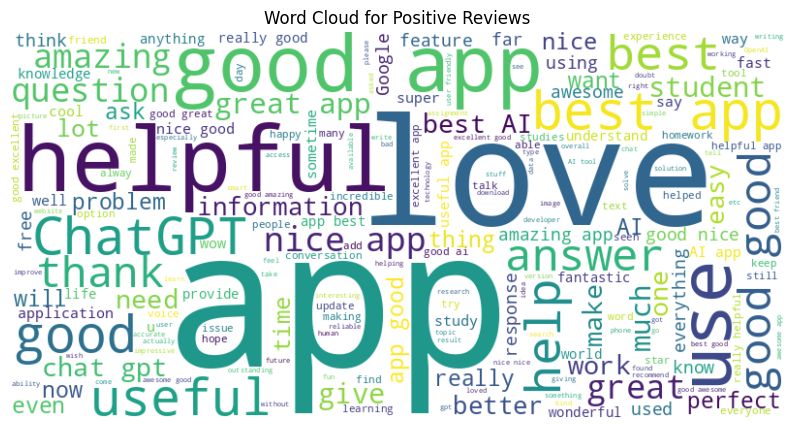

In [ ]:
#let's see word cloud for what all the most frequent words used in positive reviews
from wordcloud import WordCloud

#generating the word cloud for positive sentiment

#getting the positive reviews
positive_reviews= reviews[reviews['Sentiment']=='Positive']['Review']
positive_text=' '.join(positive_reviews)
wordcloud= WordCloud(width=800, height=400, background_color='white').generate(positive_text)

#plotting the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

Wow!! Isn't this a beautiful picture.

## **Step 4.2: Extracting most common phrases**

The strategy in the below code block is going to be we will use the Count Vectorizer to get the count using n-grams feature and then creating bag of words and counting the frequency by which these phrases are occurring.

In [ ]:
#using CountVectorizer
#n_gram range is configured to extract bigrams(2-word sequences) and trigrams(3-word sequences)
#stop_words have been configured to be ignored so that instead of words like the, and etc. we can focus on more meaningful terms
vectorizer= CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=100)

#tranforming the text into a bag-of-words representation
#fit_tranform is being used to learn the vocabulary based on 2 and 3 word sequences
#here every row will be the document(review)
#each column will represent to the n-grams
#values of X vector will capture how often that word appears in each document
X=vectorizer.fit_transform(positive_reviews)

#summarizing the count of each phrase
phrase_count= X.sum(axis=0)

#extracting the n-grams and their frequencies
phrases=vectorizer.get_feature_names_out()

phrase_freq=[(phrases[i], phrase_count[0,i]) for i in range(len(phrases))]

#sorting the phrases by frequency
phrase_freq=sorted(phrase_freq, key=lambda x:x[1], reverse=True)

#creating a dataframe to store and display the results
phrase_df= pd.DataFrame(phrase_freq, columns=['Phrase', 'Frequency'])



In [72]:
#again plotting the results
figure=px.bar(phrase_df, x='Frequency', y='Phrase', orientation='h', title='Top Phrases in positive reviews', labels={'Phrase':'Phrase', 'Frequency':'Frequency'}, width=1000, height=600, color_discrete_sequence=['green'] )

figure.update_layout(xaxis_title='Frequency', yaxis_title='Phrase', yaxis={'categoryorder':'total ascending'})

figure.show()



**We see that most of the users find ChatGPT to be a very useful app. User friendly indicates that users find the UI of ChatGPT easy to use. App students can indicate that this app is very helpful for students.**

# **Step 5: Analysis why users don't like ChatGPT**

This is going to be very similar to what we did for positive reviews. From negative reviews we will be able to find if any feature or some other cause for users don't like this application.

## **Step 5.1: Creating the word cloud**

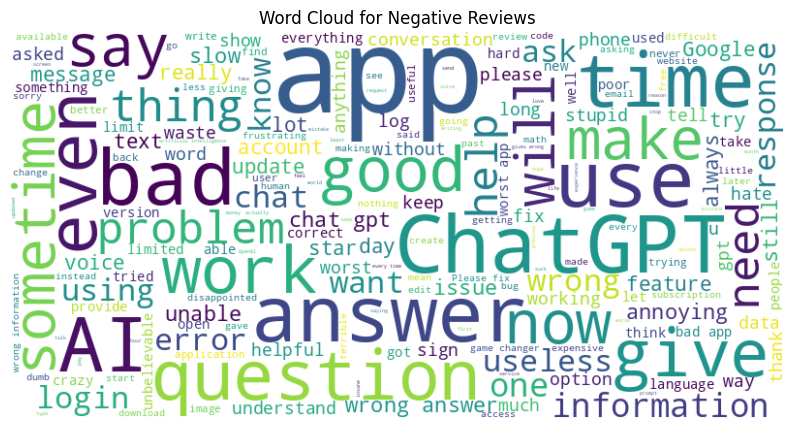

In [68]:
#let's see word cloud for what all the most frequent words used in positive reviews
from wordcloud import WordCloud

#generating the word cloud for positive sentiment

#getting the positive reviews
negative_reviews= reviews[reviews['Sentiment']=='Negative']['Review']
negative_text=' '.join(negative_reviews)
wordcloud= WordCloud(width=800, height=400, background_color='white').generate(negative_text)

#plotting the word cloud
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

So we see that limited ability[in free version], some bug fix, sometimes ChatGPT can also share wrong answer, we also see somebody has provided review regarding the voice feature, wrong information might be the reason as well.

In [74]:
#using CountVectorizer
#n_gram range is configured to extract bigrams(2-word sequences) and trigrams(3-word sequences)
#stop_words have been configured to be ignored so that instead of words like the, and etc. we can focus on more meaningful terms
vectorizer= CountVectorizer(ngram_range=(2,3), stop_words='english', max_features=100)

#tranforming the text into a bag-of-words representation
#fit_tranform is being used to learn the vocabulary based on 2 and 3 word sequences
#here every row will be the document(review)
#each column will represent to the n-grams
#values of X vector will capture how often that word appears in each document
X=vectorizer.fit_transform(negative_reviews)

#summarizing the count of each phrase
phrase_count= X.sum(axis=0)

#extracting the n-grams and their frequencies
phrases=vectorizer.get_feature_names_out()

phrase_freq=[(phrases[i], phrase_count[0,i]) for i in range(len(phrases))]

#sorting the phrases by frequency
phrase_freq_neg=sorted(phrase_freq, key=lambda x:x[1], reverse=True)

#creating a dataframe to store and display the results
phrase_neg_df= pd.DataFrame(phrase_freq, columns=['Phrase', 'Frequency'])

In [75]:
#again plotting the results
figure=px.bar(phrase_neg_df, x='Frequency', y='Phrase', orientation='h', title='Top Phrases in negative reviews', labels={'Phrase':'Phrase', 'Frequency':'Frequency'}, width=1000, height=600, color_discrete_sequence=['red'] )

figure.update_layout(xaxis_title='Frequency', yaxis_title='Phrase', yaxis={'categoryorder':'total ascending'})

figure.show()


So from the above chart, we have observed that most common issue might be ChatGPT was not able to provide correct informatio which lead to reviews like knowledge base. And don download could also indicate that some of the results provided by ChatGPT users were not able to export or download.

These issues can be classified under app's reliability, accuracy[very important] and the overall performance.

# **Step 6: Finding common problems faced by users in ChatGPT**

Since we saw from section 5 what were msot frequent words in negative reviews.

In the below section we will divide these phrases into broader problem areas and visualize them as top common issues.

In [76]:
#grouping the similar phrase into broader categories
problem_keywords = {
    'Incorrect Answers': ['wrong answer', 'gives wrong', 'incorrect', 'inaccurate', 'wrong'],
    'App Performance': ['slow', 'lag', 'crash', 'bug', 'freeze', 'loading', 'glitch', 'worst app', 'bad app', 'horrible', 'terrible'],
    'User Interface': ['interface', 'UI', 'difficult to use', 'confusing', 'layout'],
    'Features Missing/Not Working': ['feature missing', 'not working', 'missing', 'broken', 'not available'],
    'Quality of Responses': ['bad response', 'useless', 'poor quality', 'irrelevant', 'nonsense']
}

#keeping track of count problems

problem_counts={key:0 for key in problem_keywords.keys()}

#counting the frequencies
for phrase, count in phrase_freq_neg:
  for problem, keywords in problem_keywords.items():
    if any(keyword in phrase for keyword in keywords):
      problem_counts[problem]+=count
      break

#creating a new dataframe for common problems
problem_df = pd.DataFrame(list(problem_counts.items()), columns=['Problem', 'Frequency'])



In [79]:
#again plotting the results
figure=px.bar(problem_df,
             x='Frequency',
             y='Problem',
             orientation='h',
             title='Common Problems Faced by Users in ChatGPT',
             labels={'Problem': 'Problem', 'Frequency': 'Frequency'},
             width=1000,
             height=600)

figure.update_layout(xaxis_title='Frequency', yaxis_title='Phrase', yaxis={'categoryorder':'total ascending'})

figure.show()

**The most pain areas for the users are:**
1. Incorrect answers
2. App performance
3. Qualtiy responses

These areas can be used as to where improvments could be made to enhance the user experience with ChatGPT.

# **Step 7: Analyzing how reviews have changed over time[Time Series Analysis]**

To analyze how the reviews have changed over time:
1. Aggregate the reviews by their sentiment
2. Visualize the trends in the volumne of each sentiment type over time

In [81]:
#aggreagting sentiment counts by date
sentiment_over_time= reviews.groupby([reviews['Review Date'].dt.to_period('M'), 'Sentiment']).size().unstack(fill_value=0)

#converting the period back to datatime for plotting
sentiment_over_time.index= sentiment_over_time.index.to_timestamp()



In [82]:
#plotting the results
fig = go.Figure()

fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Positive'],
                         mode='lines', name='Positive', line=dict(color='green')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Neutral'],
                         mode='lines', name='Neutral', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=sentiment_over_time.index, y=sentiment_over_time['Negative'],
                         mode='lines', name='Negative', line=dict(color='red')))

fig.update_layout(
    title='Sentiment Trends Over Time',
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    plot_bgcolor='white',
    paper_bgcolor='white',
    legend_title_text='Sentiment',
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()

**Some observation from the above graph:**
1. From the visualization we see that overall number of positiev reviews for ChatGPT have increased over time, with a significant increase in May 2024 followed by a sublte decline in July 2024.
2. Neutral review also show a gradual increase over time wiht a peak in May 2024.
3. Negative reveiws however have remained stable and a slight increase has been observed in may 2024. The overall sentiment is largely positive with a steady but minimal increase in negative feedback.

# **Step 8: Analyzing how often users promote ChatGPT**

In the last section we can see how often users promote ChatGPT.
The concept of Net promoted scoe will be used. NPS is a very commonly used method to understand customer satisfaction by asking users how likely it is that they will recommend the product or services.

Below defines how the NPS is calculated:
1. Promoters: Respondents who provide a score of 9 or 10.
2. Passives: Respondents who provide a score of 7 or 8.
3. Detractors: Respondents who provide a score between 0 and 6.

NPS= %Promoters - %Detractors

We can start with assumption, that users who rate the app with 5 starts are promoters, 4 stars are passives and those with 3 or below rating below are detractors. Let's calculate the NPS.

In [84]:
#defining the categories first
reviews['NPS category']=reviews['Ratings'].apply(lambda x: 'Promoter' if x==5 else('Passive' if x==4 else 'Detractor'))

#calculating the percentage of each category
nps_counts=reviews['NPS category'].value_counts(normalize=True)*100

#calculating the NPS score
nps_score=nps_counts.get('Promoter',0)- nps_counts.get('Detractor',0)

#printing the scores
print(nps_score)

64.355101895578


NPS score for ChatGPT based on the ratings provided in the dataset, is approximately 64.35. This indicate a very strong likelihood that users would recommend ChatGPT to others, a score over 50 is generally considered excellent.

========================================This marks end of this notebook=================================================